# Compile the main simulator code using cython 

In [1]:
!python setup.py build_ext --inplace

running build_ext
running build_ext


# Import all the relevant files 

In [2]:
# Import the pipeline creation object
import pandas as pd
import numpy as np
import cbgt as cbgt
import pipeline_creation as pl_creat
import plotting_functions as plt_func
import plotting_helper_functions as plt_help
import postprocessing_helpers as post_help


import importlib

importlib.reload(plt_help)
importlib.reload(plt_func)
importlib.reload(post_help)


%load_ext autoreload
%autoreload 2
%reload_ext autoreload 

import warnings
warnings.simplefilter('ignore', category=FutureWarning)

# Choose the experiment and create the main pipeline

In [7]:
# Choose the experiment:
experiment_choice = 'n-choice'

if experiment_choice == 'stop-signal':
    import paramfile_stopsignal as paramfile
elif experiment_choice == 'n-choice':
    import paramfile_nchoice as paramfile

number_of_choices = 3

# Call choose_pipeline with the pipeline object
pl_creat.choose_pipeline(experiment_choice)

#Create the main pipeline
pl = pl_creat.create_main_pipeline(runloop=True)

# how many simulations do you want to run ? each simulation is executed as a seperate thread

num_sims = 1

num_cores = 7
# set a seed
import time
np.random.seed(int(time.time()))
#seed = np.random.choice(np.random.randint(0,9999999,100),1)[0]
seed = 8867366
print(seed)


in choose pipeline
in reward pipeline
8867366


In [6]:

# Define the data and figure directory

data_dir = "./Data/"
figure_dir = "./Figures/"



# Modify cellular parameters as desired. 
### The paramfile has all the parameter dictionaries that can be modified. They are listed as below:
- celldefaults (neuronal parameters)
- d1defaults (dSPN parameters)
- d2defaults (iSPN parameters)
- dpmndefaults (dopamine related parameters)
- basestim (background input for the nuclei)
- popspecific (population specific parameters)
- receptordefaults (GABA, AMPA receptor parameters)
### The details of each of these dictionaries can be checked by simply typing paramfile.<parameter name> as also shown in the block below

In [4]:
# list out the available parameter dictionaries
dir(paramfile)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'basestim',
 'celldefaults',
 'd1defaults',
 'd2defaults',
 'dpmndefaults',
 'np',
 'pd',
 'popspecific',
 'receptordefaults']

In [5]:
# view (or edit) one of the parameter dictionaries
paramfile.celldefaults

{'N': 75,
 'C': 0.5,
 'Taum': 20,
 'RestPot': -70,
 'ResetPot': -55,
 'Threshold': -50,
 'RestPot_ca': -85,
 'Alpha_ca': 0.5,
 'Tau_ca': 80,
 'Eff_ca': 0.0,
 'tauhm': 20,
 'tauhp': 100,
 'V_h': -60,
 'V_T': 120,
 'g_T': 0,
 'g_adr_max': 0,
 'Vadr_h': -100,
 'Vadr_s': 10,
 'ADRRevPot': -90,
 'g_k_max': 0,
 'Vk_h': -34,
 'Vk_s': 6.5,
 'tau_k_max': 8,
 'n_k': 0,
 'h': 1}

# Running the pipeline

### 1. Default values of environment variable

In [6]:
#See init_params.py / generateepochs.py / popconstruct.py / qvalues.py
#to know the parameters contained in each of the following variables 
configuration = {
    'experimentchoice': experiment_choice,
    'inter_trial_interval': None, # default = 600ms
    'thalamic_threshold': None, # default 30sp/s
    'movement_time':None,# #default sampled from N(250,1.5), ["constant",250], ["mean",250]
    'choice_timeout':None, #wait for a choice to be made, default 1000, 
    'params': paramfile.celldefaults,  #neuron parameters
    'pops': paramfile.popspecific,    #population parameters
    'receps' : paramfile.receptordefaults, #receptor parameters
    'base' : paramfile.basestim,   #baseline stimulation parameters
    'dpmns' : paramfile.dpmndefaults,  #dopamine related parameters
    'd1' : paramfile.d1defaults,     #dSPNs population related parameters
    'd2' : paramfile.d2defaults,     #iSPNs population related parameters
    'channels' : pd.DataFrame([["A"],["B"],["C"]], columns=['action']), #action channels related parameters (init_params.py)
    'number_of_choices':number_of_choices,
    #'actionchannels' : pd.DataFrame([[1],[2]], columns=['action']), #labels for the actions (init_params.py)
    #'actionchannels' : pd.DataFrame([["left"],["right"]], columns=['action']), #labels for the actions (init_params.py)
    'newpathways' :None,
    'Q_support_params': None,#pd.DataFrame([[85,0.6]],columns=['dpmn_CPP_scale','q_alpha']), #initialization of Q-values update (qvalues.py) 
    'Q_df_set':pd.DataFrame([[0.5, 0.5,0.5]],columns=["A","B","C"]), #initialized Q-values df (qvalues.py)  
    'n_trials': 3, #number of trials (generateepochs.py)
    'volatility': [1,"exact"], #frequency of changepoints and type of change points (exact or poisson) (generateepochs.py)
    'conflict': (0.7, 0.3,0.4), #probability of the preferred choice (generateepochs.py)
    'reward_mu': 1, #mean for the magnitude of the reward (generateepochs.py)
    'reward_std': 0.01, #std for the magnitude of the reward (generateepochs.py)
    'maxstim': 0.8, # 3 instead? how much stimulus the LIP gets at maximum
    'corticostriatal_plasticity_present':False, # whether plasticity is on or "off" at corticostriatal synapses
    'record_variables':["weight","optogenetic_input"],#"optogenetic_input"],
    'opt_signal_present':[True, True],
    'opt_signal_probability':[[0],[1]], # probability of trials that will get the optogenetic signal / list of trial numbers
    'opt_signal_amplitude':[0.1, -0.5], # ampitude of the stop signal over base line
    'opt_signal_onset':[10.,10.], # in ms
    'opt_signal_duration':["phase 0",400.],
    'opt_signal_channel': ["all","all"], # "all" (all channels are given the stop signal) 
    'opt_signal_population':["iSPN","dSPN"],
    'sustainedfraction':0.7
                                #/"any" (channel given the stop signal is chosen randomly)
                                # [list of channels] == subset of channels given the stop signal
    
}


### Run the simulation - 1 thread with the environment variable

In [8]:
# pl.modulelist

In [9]:
results = cbgt.ExecutionManager(cores=num_cores).run([pl]*num_sims,[configuration]*num_sims)


SpawnThreadManagers <backend.Pipeline object at 0x7fcad0831520>
(worker pid=957762) in choose pipeline
(worker pid=957762) in choose pipeline
(worker pid=957762) change points: [0 1 2 2]
(worker pid=957762) conflict (0.7, 0.3, 0.4)
(worker pid=957762) conflict (0.7, 0.3, 0.4)
(worker pid=957762) sum 1.4
(worker pid=957762) n_prob_trials [0, 0, 0]
(worker pid=957762) calc_rew      A    B    C
(worker pid=957762) 0  0.0  0.0  0.0
(worker pid=957762) reward_list      A    B    C
(worker pid=957762) 0  0.0  0.0  0.0
(worker pid=957762) conflict (0.7, 0.3, 0.4)
(worker pid=957762) sum 1.4
(worker pid=957762) n_prob_trials [0, 0, 0]
(worker pid=957762) calc_rew      B    C    A
(worker pid=957762) 0  0.0  0.0  0.0
(worker pid=957762) reward_list      B    C    A
(worker pid=957762) 0  0.0  0.0  0.0
(worker pid=957762) change points: [0 1 2 2]
(worker pid=957762) conflict (0.7, 0.3, 0.4)
(worker pid=957762) conflict (0.7, 0.3, 0.4)
(worker pid=957762) sum 1.4
(worker pid=957762) n_prob_trials

(worker pid=957762) /home/jyotika/Work/CBGTPy_release/CBGTPy/qvalues.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(worker pid=957762)   Q_df = Q_df.append(
(worker pid=957762) /home/jyotika/Work/CBGTPy_release/CBGTPy/qvalues.py:121: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(worker pid=957762)   Q_df = Q_df.append(
(worker pid=957762) /home/jyotika/Work/CBGTPy_release/CBGTPy/qvalues.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(worker pid=957762)   Q_df = Q_df.append(
(worker pid=957762) /home/jyotika/Work/CBGTPy_release/CBGTPy/qvalues.py:121: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(worker pid=957762)   Q_df = Q_df.

(worker pid=957762) agent.opt_popids [array([12, 13, 14]), array([ 9, 10, 11])]
(worker pid=957762) agent.opt_popids [array([12, 13, 14]), array([ 9, 10, 11])]
(worker pid=957762) phasetimer 1001
(worker pid=957762) gateFRs [18.         20.22222222 14.22222222]
(worker pid=957762) thresholds_crossed []
(worker pid=957762) phasetimer 1001
(worker pid=957762) gateFRs [18.         20.22222222 14.22222222]
(worker pid=957762) thresholds_crossed []
(worker pid=957762) trial_num 0
(worker pid=957762) chosen_action none
(worker pid=957762) scaled dopamine signal 0.0`
(worker pid=957762) trial_num 0
(worker pid=957762) chosen_action none
(worker pid=957762) scaled dopamine signal 0.0`
(worker pid=957762) opt stim started
(worker pid=957762) opt stim started
(worker pid=957762) phasetimer 666
(worker pid=957762) gateFRs [26.22222222 21.33333333 30.44444444]
(worker pid=957762) thresholds_crossed [2]
(worker pid=957762) phasetimer 666
(worker pid=957762) gateFRs [26.22222222 21.33333333 30.44444

In [10]:
# List all the agent variables accessible
results[0].keys()

dict_keys(['experimentchoice', 'inter_trial_interval', 'thalamic_threshold', 'movement_time', 'choice_timeout', 'params', 'pops', 'receps', 'base', 'dpmns', 'd1', 'd2', 'channels', 'number_of_choices', 'newpathways', 'Q_support_params', 'Q_df_set', 'n_trials', 'volatility', 'conflict', 'reward_mu', 'reward_std', 'maxstim', 'corticostriatal_plasticity_present', 'record_variables', 'opt_signal_present', 'opt_signal_probability', 'opt_signal_amplitude', 'opt_signal_onset', 'opt_signal_duration', 'opt_signal_channel', 'opt_signal_population', 'sustainedfraction', 'par', 'popconstruct', 'interface', 'actionchannels', 'trial_wise_movement_times', 'volatile_pattern', 'cp_idx', 'cp_indicator', 'noisy_pattern', 't_epochs', 'block', 'trial_num', 'chosen_action', 'celldefaults', 'popspecific', 'receptordefaults', 'basestim', 'dpmndefaults', 'd1defaults', 'd2defaults', 'popdata', 'pathways', 'opt_df', 'opt_channels_dfs', 'opt_amplitude_dfs', 'opt_onset_dfs', 'opt_duration_dfs', 'opt_populations_df

In [11]:
results[0]['meaneff_GABA']

,GPi,GPi,GPi,STN,STN,STN,GPe,GPe,GPe,dSPN,...,iSPN,iSPN,Cx,Cx,Cx,Th,Th,Th,FSI,CxI
GPi,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.3315`,0.0`,0.0`,0.0`,0.0`
GPi,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.3315`,0.0`,0.0`,0.0`
GPi,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.3315`,0.0`,0.0`
STN,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
STN,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
STN,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
GPe,0.058`,0.0`,0.0`,0.35`,0.0`,0.0`,1.75`,1.75`,1.75`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
GPe,0.0`,0.058`,0.0`,0.0`,0.35`,0.0`,1.75`,1.75`,1.75`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
GPe,0.0`,0.0`,0.058`,0.0`,0.0`,0.35`,1.75`,1.75`,1.75`,0.0`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
dSPN,2.09`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.28`,...,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`


In [12]:
results[0]['conflict']

(0.7, 0.3, 0.4)

In [13]:
results[0]['Q_df']

,A,B,C
0,0.5,0.5,0.5
0,0.5,0.5,0.5
0,0.5,0.5,0.5
0,0.5,0.5,0.5


In [14]:
experiment_choice

'n-choice'

In [15]:
#Extract all the relevant dataframes
firing_rates, reward_q_df, performance, rt_dist, total_performance = plt_help.extract_relevant_frames(results,seed,experiment_choice)

/home/jyotika/Work/CBGTPy_release/CBGTPy/plotting_helper_functions.py:118: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = Q_df_local.append(rew_df)
/home/jyotika/Work/CBGTPy_release/CBGTPy/plotting_helper_functions.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(chosen_action)
/home/jyotika/Work/CBGTPy_release/CBGTPy/plotting_helper_functions.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(block)
/home/jyotika/Work/CBGTPy_release/CBGTPy/plotting_helper_functions.py:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf = perf.append({'%_rewarded_actio

In [16]:
results[0]['popfreqs']

,GPi_A,GPi_B,GPi_C,STN_A,STN_B,STN_C,GPe_A,GPe_B,GPe_C,dSPN_A,...,iSPN_C,Cx_A,Cx_B,Cx_C,Th_A,Th_B,Th_C,FSI_common,CxI_common,Time (ms)
0,66.888889,67.333333,64.444444,24.977778,25.088889,27.333333,62.111111,58.377778,60.066667,3.777778,...,5.555556,0.000000,0.000000,0.000000,6.000000,10.444444,7.333333,8.222222,0.806452,0
1,67.111111,68.444444,64.888889,24.866667,25.288889,27.577778,61.822222,57.622222,60.866667,3.777778,...,5.111111,0.000000,0.000000,0.000000,6.444444,10.222222,7.111111,8.444444,0.896057,1
2,66.444444,68.888889,64.888889,24.866667,25.644444,27.355556,62.066667,56.933333,61.777778,4.000000,...,5.111111,0.000000,0.000000,0.000000,6.444444,10.222222,7.111111,8.222222,0.896057,2
3,65.777778,69.333333,65.555556,24.755556,25.844444,26.933333,61.933333,57.066667,62.533333,4.000000,...,5.333333,0.000000,0.000000,0.000000,6.222222,10.000000,6.888889,8.222222,0.896057,3
4,65.111111,68.888889,64.888889,24.644444,25.866667,26.644444,61.266667,56.777778,62.444444,4.000000,...,5.333333,0.000000,0.000000,0.000000,6.222222,9.777778,6.888889,8.222222,0.806452,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4402,63.555556,73.111111,72.444444,27.866667,25.111111,25.844444,58.488889,65.200000,58.866667,6.666667,...,5.555556,0.326797,0.735294,0.980392,10.666667,6.000000,9.555556,7.777778,1.881720,4402
4403,62.888889,72.666667,72.444444,28.000000,24.955556,26.022222,58.400000,65.266667,59.111111,6.444444,...,5.555556,0.326797,0.735294,0.980392,10.888889,6.222222,9.333333,7.777778,1.881720,4403
4404,63.555556,72.444444,74.000000,28.000000,25.022222,26.000000,58.000000,65.022222,58.777778,6.444444,...,6.222222,0.326797,0.735294,0.980392,11.111111,6.000000,9.111111,7.777778,1.881720,4404
4405,63.555556,72.000000,73.777778,28.000000,24.866667,25.933333,58.022222,65.177778,58.022222,6.444444,...,6.222222,0.326797,0.653595,0.898693,11.111111,6.000000,8.888889,7.777778,1.792115,4405


In [17]:
# firing rates  
firing_rates[0]

,Time (ms),variable,firing_rate,nuclei,channel,seed,n_trials,volatility,volatility_type,conflict
0,0,GPi_A,66.888889,GPi,A,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"
1,1,GPi_A,67.111111,GPi,A,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"
2,2,GPi_A,66.444444,GPi,A,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"
3,3,GPi_A,65.777778,GPi,A,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"
4,4,GPi_A,65.111111,GPi,A,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"
...,...,...,...,...,...,...,...,...,...,...
101356,4402,CxI_common,1.881720,CxI,common,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"
101357,4403,CxI_common,1.881720,CxI,common,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"
101358,4404,CxI_common,1.881720,CxI,common,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"
101359,4405,CxI_common,1.792115,CxI,common,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)"


In [18]:
performance

,%_rewarded_actions,%_action,actions,block,seed,n_trials,volatility,volatility_type,conflict,condition
0,0.0,33.333333,none,A,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
1,0.0,33.333333,C,B,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
2,0.0,33.333333,B,C,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation


In [19]:
recorded_variables = post_help.extract_recording_variables(results,results[0]['record_variables'],seed)

['A' 'B' 'C']
nuc_list ['dSPN-A' 'iSPN-A' 'dSPN-B' 'iSPN-B' 'dSPN-C' 'iSPN-C']
ind_list [[0 0 1 0 2 0]
 [0 1 1 1 2 1]]


/home/jyotika/Work/CBGTPy_release/CBGTPy/postprocessing_helpers.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(temp_ac)
/home/jyotika/Work/CBGTPy_release/CBGTPy/postprocessing_helpers.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(temp_ac)
/home/jyotika/Work/CBGTPy_release/CBGTPy/postprocessing_helpers.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(temp_ac)
/home/jyotika/Work/CBGTPy_release/CBGTPy/postprocessing_helpers.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(temp_ac)
/home/jyotika/Work/CBGTPy_release/CBGTPy/postprocessing_helpers.

In [20]:
recorded_variables['weight']

,weights,trials,nuclei,seed
0,0.015,0,dSPN-A,8867366_0
1,0.015,1,dSPN-A,8867366_0
0,0.015,0,iSPN-A,8867366_0
1,0.015,1,iSPN-A,8867366_0
0,0.015,0,dSPN-B,8867366_0
1,0.015,1,dSPN-B,8867366_0
0,0.015,0,iSPN-B,8867366_0
1,0.015,1,iSPN-B,8867366_0
0,0.015,0,dSPN-C,8867366_0
1,0.015,1,dSPN-C,8867366_0


In [21]:
recorded_variables['optogenetic_input'].nuclei.unique()

array(['iSPN-A', 'iSPN-B', 'iSPN-C', 'dSPN-A', 'dSPN-B', 'dSPN-C'],
      dtype=object)

In [22]:
recorded_variables['optogenetic_input']

,index,value,nuclei,Time(ms),seed
0,0,1.4,iSPN-A,0,8867366_0
1,1,1.4,iSPN-A,1,8867366_0
2,2,1.4,iSPN-A,2,8867366_0
3,3,1.4,iSPN-A,3,8867366_0
4,4,1.4,iSPN-A,4,8867366_0
...,...,...,...,...,...
26431,4401,1.3,dSPN-C,4401,8867366_0
26432,4402,1.3,dSPN-C,4402,8867366_0
26433,4403,1.3,dSPN-C,4403,8867366_0
26434,4404,1.3,dSPN-C,4404,8867366_0


<AxesSubplot:xlabel='trials', ylabel='weights'>

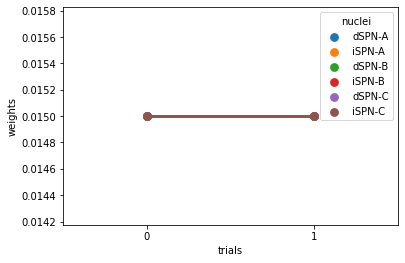

In [23]:
import seaborn as sns
import pylab as pl
sns.pointplot(x="trials",y="weights",hue="nuclei",data=recorded_variables['weight'])


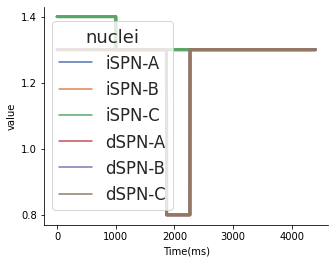

In [24]:
fig,ax = pl.subplots(1,1,figsize=(5,4))
sns.set(style="white", font_scale=1.5)
sns.lineplot(x="Time(ms)",y="value",data=recorded_variables['optogenetic_input'],hue='nuclei',lw=3.0,ax=ax)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
pl.tight_layout()
fig.savefig(figure_dir+'optogenetic_stimulation.png')


In [25]:
# Relevant reward_dataframe
reward_q_df[0]

,level_0,index,Trials,variable,value,data_type,seed,n_trials,volatility,volatility_type,conflict,condition
0,0,4,0,A,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
1,1,5,1,A,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
2,2,6,2,A,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
3,3,7,3,A,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
4,4,8,0,B,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
5,5,9,1,B,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
6,6,10,2,B,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
7,7,11,3,B,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
8,8,12,0,C,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
9,9,13,1,C,0.5,Q_df,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation


In [26]:
performance

,%_rewarded_actions,%_action,actions,block,seed,n_trials,volatility,volatility_type,conflict,condition
0,0.0,33.333333,none,A,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
1,0.0,33.333333,C,B,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation
2,0.0,33.333333,B,C,8867366_0,3.0,1,exact,"(0.7, 0.3, 0.4)",iSPN-Stimulation


In [27]:
# Extract the data tables from the agent
datatables = cbgt.collateVariable(results,'datatables')
datatables[0]["decisiondurationplusdelay"]-datatables[0]["decisionduration"]

0    254
1    252
2    252
dtype: object

In [28]:
datatables[0]

,decision,stimulusstarttime,decisiontime,decisionduration,decisiondurationplusdelay,rewardtime,correctdecision,reward
0,none,0,1001,1001,1255,1255,A,0
1,C,1856,2522,666,918,2774,B,0
2,B,3375,3553,178,430,3805,C,0


In [29]:
# Check the Q-values data frame
results[0]['Q_df']

,A,B,C
0,0.5,0.5,0.5
0,0.5,0.5,0.5
0,0.5,0.5,0.5
0,0.5,0.5,0.5


In [30]:
# postfix = "weak_GPi_inh"
postfix = ""

In [31]:
#Save the selected variables of results in the data_dir specified
cbgt.saveResults(results,data_dir+'network_data_'+postfix+'_'+str(seed)+'.pickle',['popfreqs','popdata','Q_support_params','d1','d2','dpmns','datatables'])


In [32]:
firing_rates[0].to_csv(data_dir+"firing_rates_"+postfix+".csv")
reward_q_df[0].to_csv(data_dir+"reward_df_"+postfix+".csv")
performance.to_csv(data_dir+"performance_"+postfix+".csv")
rt_dist.to_csv(data_dir+"rt_dist_"+postfix+".csv")
total_performance.to_csv(data_dir+"total_performance_"+postfix+".csv")

In [33]:
reward_q_df

[    level_0  index  Trials variable  value      data_type       seed  \
 0         0      4       0        A    0.5           Q_df  8867366_0   
 1         1      5       1        A    0.5           Q_df  8867366_0   
 2         2      6       2        A    0.5           Q_df  8867366_0   
 3         3      7       3        A    0.5           Q_df  8867366_0   
 4         4      8       0        B    0.5           Q_df  8867366_0   
 5         5      9       1        B    0.5           Q_df  8867366_0   
 6         6     10       2        B    0.5           Q_df  8867366_0   
 7         7     11       3        B    0.5           Q_df  8867366_0   
 8         8     12       0        C    0.5           Q_df  8867366_0   
 9         9     13       1        C    0.5           Q_df  8867366_0   
 10       10     14       2        C    0.5           Q_df  8867366_0   
 11       11     15       3        C    0.5           Q_df  8867366_0   
 12        0      0       0        A    0.0      re

In [34]:
results[0]['opt_list_trials_list'][1]

[1]

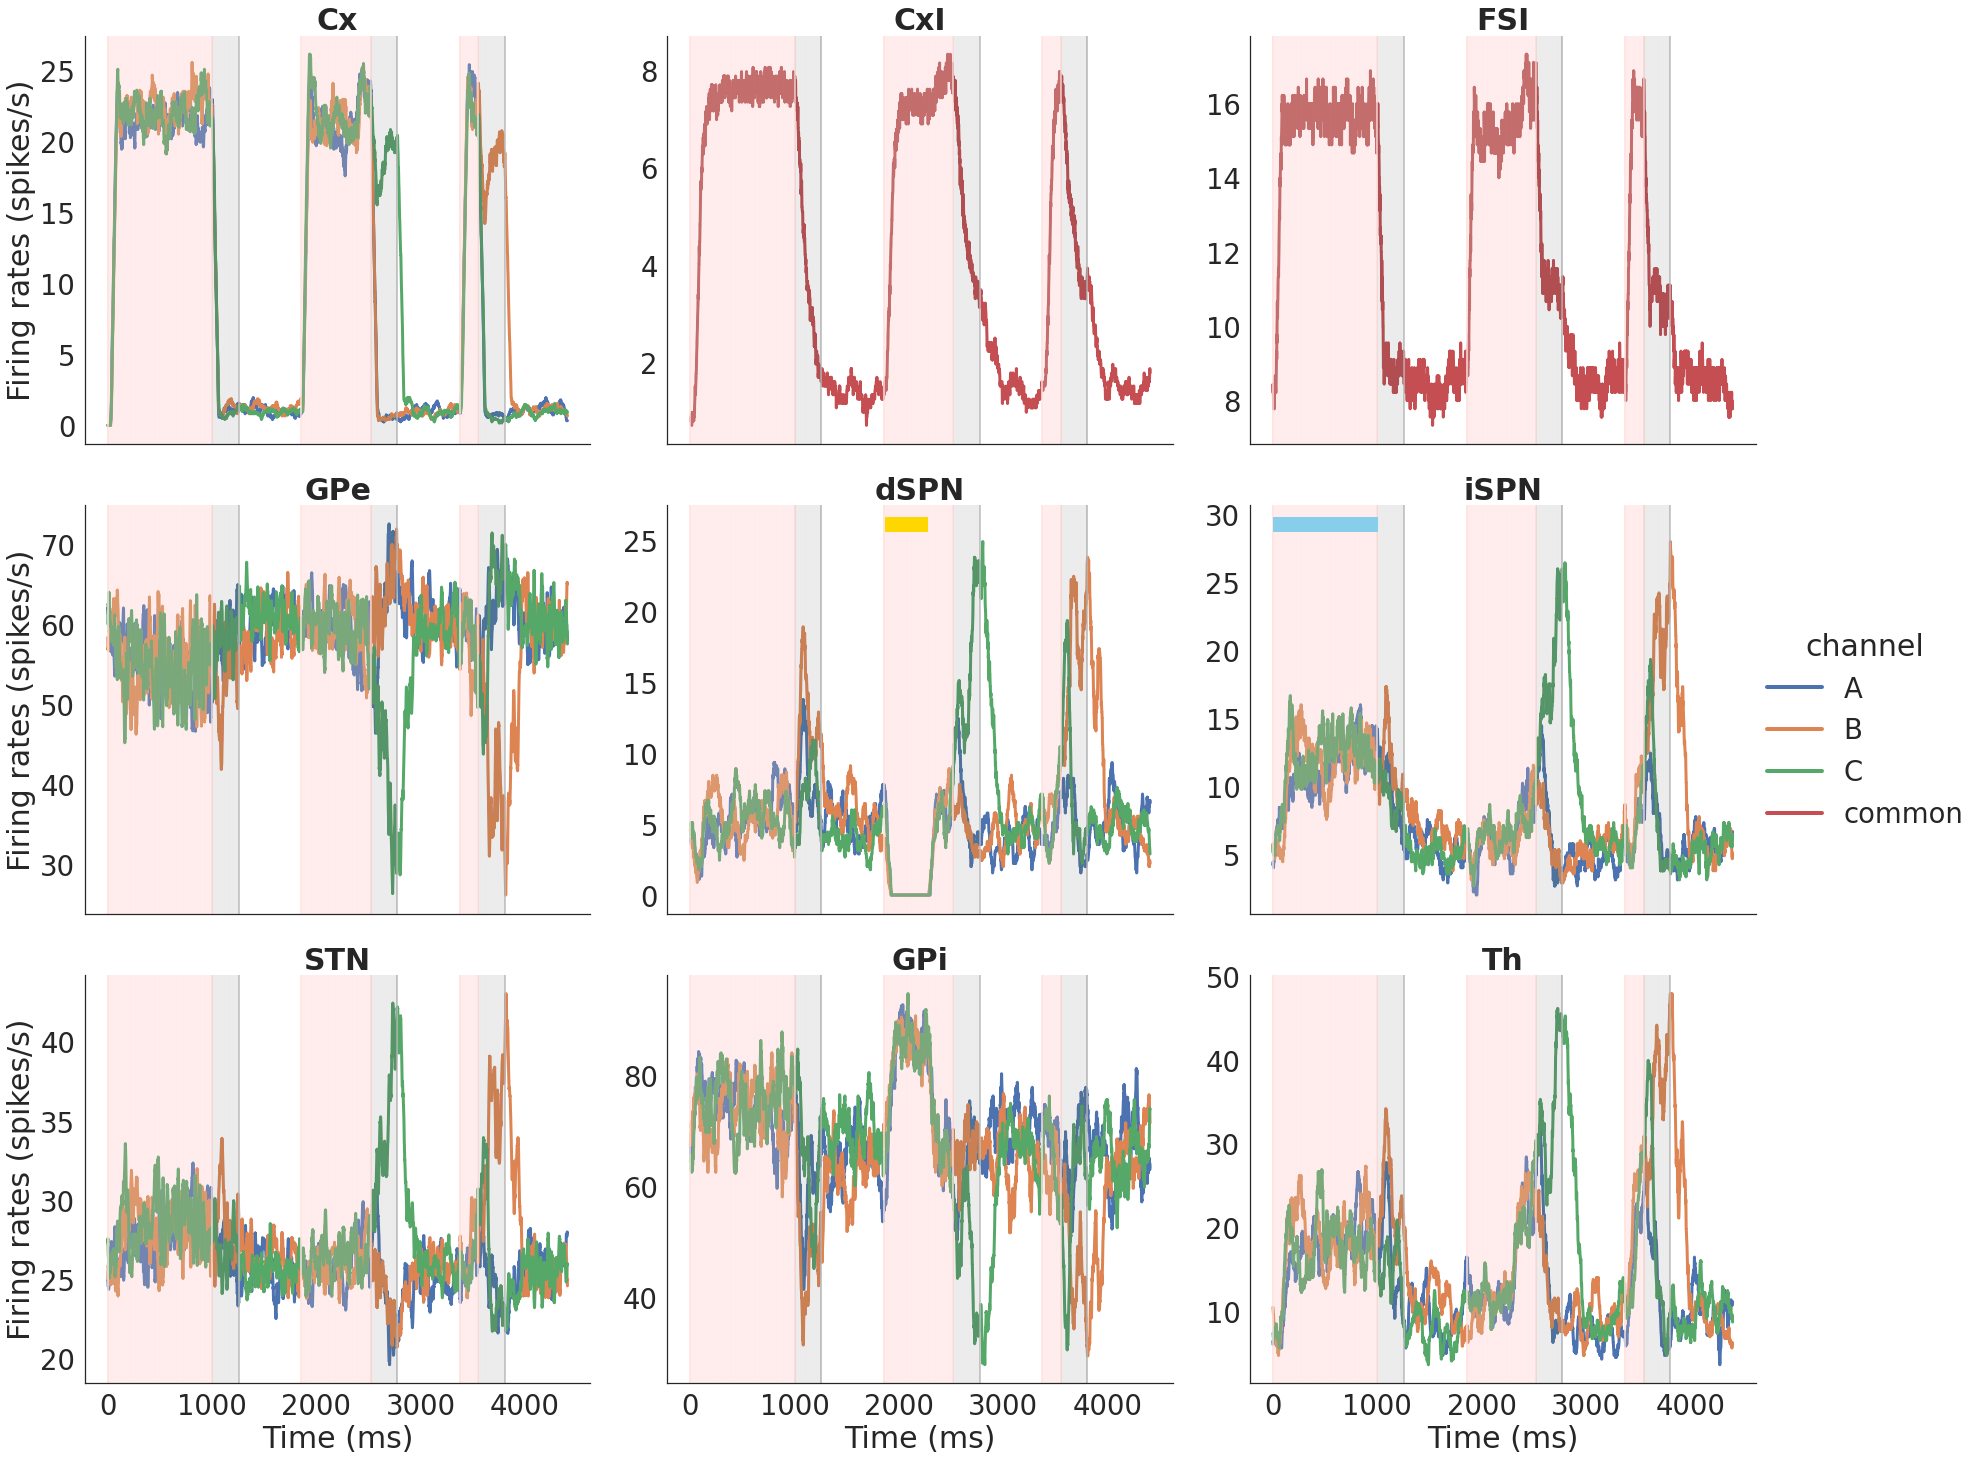

In [35]:
# Plot the firing rates extracted, figure handles are returned in fig_handles

FR_fig_handles = plt_func.plot_fr(firing_rates,datatables,results,experiment_choice,True)
FR_fig_handles[0].savefig(figure_dir+"Example_FR_optostim_"+postfix+"two_stims.png",dpi=300)

In [36]:
# FR_fig_handles_zoom = plt_func.plot_fr_flex(firing_rates[0],datatables[0],['all'], [], (0, 500)) 

TypeError: plot_fr_flex() missing 2 required positional arguments: 'interval' and 'experiment_choice'

In [ ]:
reward_fig_handles = plt_func.plot_reward_Q_df(reward_q_df)